In [1]:
#CS577_Project_NitiW
#Niti Wattanasirichaigoon
#A20406934
#
# Implementation of Automatic Colorization network by 
#  Satoshi Iizuka, Edgar Simo-Serra, Hiroshi Ishikawa in Keras

from keras import layers, models, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Input, Cropping2D, UpSampling2D
from keras.layers import Conv2D, MaxPooling2D, concatenate, RepeatVector, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.backend import resize_images
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage import color

Using TensorFlow backend.


**Data Preprocessing**

In [2]:
# Select categories by ID (refer to documentation)
#['airfield', 'bamboo_forest', 'castle', 'desert', 'gas_station', 'iceberg','locker_room', 'playground', 'swimming_pool', 'waterfall']
cat_ID = [0, 36, 84, 116, 158, 190, 219, 268, 326, 355] 

# Load data into Keras
pic_dir = 'val_256/val_256/'
data_list = 'places365_val.txt'

img_data = []
labels = []
img_list = pd.read_csv(data_list, names=['file_name', 'ID'], delimiter=' ') 
img_list.astype({'ID': 'int32'}).dtypes
for IDs in range(len(cat_ID)):
    for i in range(len(img_list)):
        if img_list['ID'][i] == cat_ID[IDs]:
            image = img.imread(pic_dir + img_list['file_name'][i])
            lab = color.rgb2lab(image) #convert to Lab colorspace
            img_data.append(lab)
            labels.append(IDs)
            
img_data = np.array(img_data)
# Image data Normalization (Lab colorspace)
img_data[:,:,:,0] /= 100
img_data[:,:,:,1:3] += 128
img_data[:,:,:,1:3] /= 256

labels = to_categorical(np.array(labels))

img_train, img_valid, labels_train, labels_valid = train_test_split(img_data, labels,
                                                    stratify=labels, 
                                                    test_size=0.15)

# x = image data in Lab colorspace, y = place category label
print(len(labels_train), 'images for training')
print(len(labels_valid), 'images for validation')

850 images for training
150 images for validation


In [51]:
# FAILED ATTEMPT 
# Data augmentation with keras data generators
# *Does not work with the the class labels because its not an image
'''
def labels_as_4dArr(labels):
    # this function transforms label vectors into 4d tensors so that we can use ImageDataGenerators
    arr = np.zeros((labels.shape[0],1,1,10))
    arr = labels
    return arr

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator()

def generate_train_gen(img_train, labels_train):
    input_img = train_datagen.flow(img_train[:,:,:,0:1], seed=1, batch_size=20)
    validation_img = train_datagen.flow(img_train[:,:,:,1:3], seed=1, batch_size=20)
    class_tag = test_datagen.flow(labels_as_4dArr(labels_train), seed=1, batch_size=20)
    while True:
        X = input_img.next()
        Y1 = validation_img.next()
        Y2 = class_tag.next()
        yield X, [Y1, Y2]
        
def generate_train_gen(img_train, labels_train):
    input_img = train_datagen.flow(img_train[:,:,:,0:1], [img_train[:,:,:,1:3], labels_train], batch_size=20)
    validation_img = train_datagen.flow(img_train[:,:,:,1:3], seed=1, batch_size=20)
    class_tag = test_datagen.flow(labels_as_4dArr(labels_train), seed=1, batch_size=20)
    while True:
        X = input_img.next()
        Y1 = validation_img.next()
        Y2 = class_tag.next()
        yield X, [Y1, Y2]
        
def generate_valid_gen(img_valid, labels_valid):
    input_img = test_datagen.flow(img_valid[:,:,:,0:1], seed=1, batch_size=20)
    validation_img = test_datagen.flow(img_valid[:,:,:,1:3], seed=1, batch_size=20)
    class_tag = test_datagen.flow(labels_as_4dArr(labels_valid), seed=1, batch_size=20)
    while True:
        X = input_img.next()
        Y1 = validation_img.next()
        Y2 = class_tag.next()
        yield X, [Y1, Y2]
        
'''

**Model Construction**

In [3]:
# Define CNN structure
# input=BW image, output = class label, a*b* colorspace

def build_model():
    from keras import backend
    input_img = Input(shape=(img_train.shape[1], img_train.shape[2], 1), name="img_input")
    input_img_global = Cropping2D(cropping=((16, 16), (16, 16)))(input_img)#crop to 224 x 224
    
    # Low-level features network (shared weights)
    LLN_layer1 = Conv2D(64, (3, 3), padding='same', strides=(2,2), name="LLN_layer1")
    LLN_layer2 = Conv2D(128, (3, 3), padding='same', strides=(1,1), name="LLN_layer2")
    LLN_layer3 = Conv2D(128, (3, 3), padding='same', strides=(2,2), name="LLN_layer3")
    LLN_layer4 = Conv2D(256, (3, 3), padding='same', strides=(1,1), name="LLN_layer4")
    LLN_layer5 = Conv2D(256, (3, 3), padding='same', strides=(2,2), name="LLN_layer5")
    LLN_layer6 = Conv2D(512, (3, 3), padding='same', strides=(1,1), name="LLN_layer6")

    local = LLN_layer1(input_img)
    local = BatchNormalization()(local)
    local = Activation("relu")(local)
    local = LLN_layer2(local)
    local = BatchNormalization()(local)
    local = Activation("relu")(local)
    local = LLN_layer3(local)
    local = BatchNormalization()(local)
    local = Activation("relu")(local)
    local = LLN_layer4(local)
    local = BatchNormalization()(local)
    local = Activation("relu")(local)
    local = LLN_layer5(local)
    local = BatchNormalization()(local)
    local = Activation("relu")(local)
    local = LLN_layer6(local)
    local = BatchNormalization()(local)
    local = Activation("relu")(local)

    globl = LLN_layer1(input_img_global)
    globl = BatchNormalization()(globl)
    globl = Activation("relu")(globl)
    globl = LLN_layer2(globl)
    globl = BatchNormalization()(globl)
    globl = Activation("relu")(globl)
    globl = LLN_layer3(globl)
    globl = BatchNormalization()(globl)
    globl = Activation("relu")(globl)
    globl = LLN_layer4(globl)
    globl = BatchNormalization()(globl)
    globl = Activation("relu")(globl)
    globl = LLN_layer5(globl)
    globl = BatchNormalization()(globl)
    globl = Activation("relu")(globl)
    globl = LLN_layer6(globl)
    globl = BatchNormalization()(globl)
    globl = Activation("relu")(globl)

    # Mid-level features network
    mid_layer1 = Conv2D(512, (3, 3), padding='same', strides=(1,1), name="ML_layer1")(local)
    mid_layer1 = BatchNormalization()(mid_layer1)
    mid_layer1 = Activation("relu")(mid_layer1)
    mid_layer2 = Conv2D(256, (3, 3), padding='same', strides=(1,1), name="ML_layer2")(mid_layer1)
    mid_layer2 = BatchNormalization()(mid_layer2)
    mid_layer2 = Activation("relu")(mid_layer2)
    
    # Global features network
    gbf_layer1 = Conv2D(512, (3, 3), padding='same', strides=(2,2), name="GFN_layer1")(globl)
    gbf_layer1 = BatchNormalization()(gbf_layer1)
    gbf_layer1 = Activation("relu")(gbf_layer1)
    gbf_layer2 = Conv2D(512, (3, 3), padding='same', strides=(1,1), name="GFN_layer2")(gbf_layer1)
    gbf_layer2 = BatchNormalization()(gbf_layer2)
    gbf_layer2 = Activation("relu")(gbf_layer2)
    gbf_layer3 = Conv2D(512, (3, 3), padding='same', strides=(2,2), name="GFN_layer3")(gbf_layer2)
    gbf_layer3 = BatchNormalization()(gbf_layer3)
    gbf_layer3 = Activation("relu")(gbf_layer3)
    gbf_layer4 = Conv2D(512, (3, 3), padding='same', strides=(1,1), name="GFN_layer4")(gbf_layer3)
    gbf_layer4 = BatchNormalization()(gbf_layer4)
    gbf_layer4 = Activation("relu")(gbf_layer4)
    flat = Flatten(name="Flatten_layer")(gbf_layer4)
    FC_layer1 = Dense(1024, name="FC_layer1")(flat)
    FC_layer1 = BatchNormalization()(FC_layer1)
    FC_layer1 = Activation("relu")(FC_layer1)
    FC_layer2 = Dense(512, name="FC_layer2")(FC_layer1)
    FC_layer2 = BatchNormalization()(FC_layer2)
    FC_layer2 = Activation("relu")(FC_layer2)
    FC_layer3 = Dense(256, name="FC_layer3")(FC_layer2)
    FC_layer3 = BatchNormalization()(FC_layer3)
    FC_layer3 = Activation("relu")(FC_layer3)

    # Classification network
    class_layer1 = Dense(256, name="FC_layer4")(FC_layer3)
    class_layer1 = BatchNormalization()(class_layer1)
    class_layer1 = Activation("relu")(class_layer1)
    class_output = Dense(10, activation='softmax', name="class_output")(class_layer1)
    
    # Fusion network
    fusion = RepeatVector(mid_layer2.shape[1] * mid_layer2.shape[2], name="Repeat_vector")(FC_layer3)
    fusion = Reshape([mid_layer2.shape[1], mid_layer2.shape[2],256], name="Reshape_layer")(fusion)
    fusion = concatenate([mid_layer2, fusion], name="fusion_layer1")
    fusion = Conv2D(256, (1, 1), name="fusion_layer2")(fusion)
    fusion = BatchNormalization()(fusion)
    fusion = Activation("relu")(fusion)
    
    # Colorization network
    color_layer1 = Conv2D(128, (3, 3), padding='same', strides=(1,1), name="CN_layer1")(fusion)
    color_layer1 = BatchNormalization()(color_layer1)
    color_layer1 = Activation("relu")(color_layer1)
    upsamp1 = UpSampling2D(name="UpSampling1")(color_layer1)
    color_layer2 = Conv2D(64, (3, 3), padding='same', strides=(1,1), name="CN_layer2")(upsamp1)
    color_layer2 = BatchNormalization()(color_layer2)
    color_layer2 = Activation("relu")(color_layer2)
    color_layer3 = Conv2D(64, (3, 3), padding='same', strides=(1,1), name="CN_layer3")(color_layer2)
    color_layer3 = BatchNormalization()(color_layer3)
    color_layer3 = Activation("relu")(color_layer3)
    upsamp2 = UpSampling2D(name="UpSampling2")(color_layer3)
    color_layer4 = Conv2D(32, (3, 3), padding='same', strides=(1,1), name="CN_layer4")(upsamp2)
    color_layer4 = BatchNormalization()(color_layer4)
    color_layer4 = Activation("relu")(color_layer4)
    output = Conv2D(2, (3, 3), padding='same', strides=(1,1), name="CN_output")(color_layer4)
    output = BatchNormalization()(output)
    output = Activation("sigmoid")(output)
    output = UpSampling2D(name="output")(output)
    
    losses = {"output": 'mse', "class_output": 'categorical_crossentropy'}
    lossWeights = {"output": 1000.0, "class_output": 1.0}
    model = models.Model([input_img], [output, class_output])
    model.compile(loss=losses, loss_weights=lossWeights, optimizer='adadelta', metrics=['mse'])
    return model

**Model Training**

In [4]:
model = build_model()
#model.summary()

**Model 1**

In [5]:
# Model 1: equal loss weights, batch size = 5
history = model.fit(
    img_train[:,:,:,0:1], [img_train[:,:,:,1:3], labels_train],
    batch_size=5,
    epochs=10,
    validation_data=(img_valid[:,:,:,0:1], [img_valid[:,:,:,1:3], labels_valid]),
    verbose=1)

Train on 850 samples, validate on 150 samples
Epoch 1/10
850/850 [==============================] - 201s 237ms/step - loss: 2.3095 - output_loss: 0.0035 - class_output_loss: 2.3060 - output_mse: 0.0035 - class_output_mse: 0.0901 - val_loss: 2.3057 - val_output_loss: 0.0031 - val_class_output_loss: 2.3026 - val_output_mse: 0.0031 - val_class_output_mse: 0.0900
Epoch 2/10
850/850 [==============================] - 176s 207ms/step - loss: 2.3075 - output_loss: 0.0035 - class_output_loss: 2.3040 - output_mse: 0.0035 - class_output_mse: 0.0900 - val_loss: 2.3057 - val_output_loss: 0.0031 - val_class_output_loss: 2.3026 - val_output_mse: 0.0031 - val_class_output_mse: 0.0900
Epoch 3/10
850/850 [==============================] - 176s 207ms/step - loss: 2.3074 - output_loss: 0.0035 - class_output_loss: 2.3039 - output_mse: 0.0035 - class_output_mse: 0.0900 - val_loss: 2.3057 - val_output_loss: 0.0031 - val_class_output_loss: 2.3026 - val_output_mse: 0.0031 - val_class_output_mse: 0.0900
Epoch 

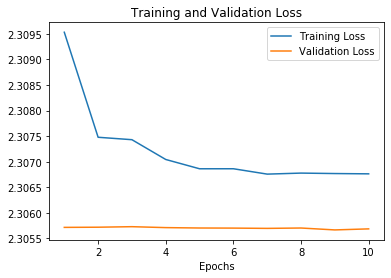

In [14]:
# Visualize training process model 1
epochs = range(1, 11)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()

**Model 2**

In [5]:
# Model 2: x1000 weight on output, batch size = 8
history = model.fit(
    img_train[:,:,:,0:1], [img_train[:,:,:,1:3], labels_train],
    batch_size=8,
    epochs=10,
    validation_data=(img_valid[:,:,:,0:1], [img_valid[:,:,:,1:3], labels_valid]),
    verbose=1)

Train on 850 samples, validate on 150 samples
Epoch 1/10
850/850 [==============================] - 176s 208ms/step - loss: 87.4399 - output_loss: 0.0085 - class_output_loss: 78.3920 - output_mse: 0.0085 - class_output_mse: 0.0913 - val_loss: 5.9712 - val_output_loss: 0.0037 - val_class_output_loss: 2.3028 - val_output_mse: 0.0037 - val_class_output_mse: 0.0900
Epoch 2/10
850/850 [==============================] - 144s 170ms/step - loss: 5.8368 - output_loss: 0.0035 - class_output_loss: 2.3059 - output_mse: 0.0035 - class_output_mse: 0.0901 - val_loss: 5.9699 - val_output_loss: 0.0037 - val_class_output_loss: 2.3020 - val_output_mse: 0.0037 - val_class_output_mse: 0.0900
Epoch 3/10
850/850 [==============================] - 145s 170ms/step - loss: 5.8532 - output_loss: 0.0036 - class_output_loss: 2.3222 - output_mse: 0.0035 - class_output_mse: 0.0907 - val_loss: 5.9734 - val_output_loss: 0.0037 - val_class_output_loss: 2.3030 - val_output_mse: 0.0037 - val_class_output_mse: 0.0900
Epoc

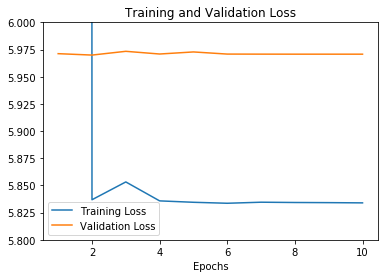

In [15]:
# Visualize training process model 2
epochs = range(1, 11)
plt.ylim(5.8, 6)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')

plt.legend()

**Model 3**

In [28]:
# Model 3: x1000 weight on output, batch size = 8, batch normalization
history = model.fit(
    img_train[:,:,:,0:1], [img_train[:,:,:,1:3], labels_train],
    batch_size=8,
    epochs=15,
    validation_data=(img_valid[:,:,:,0:1], [img_valid[:,:,:,1:3], labels_valid]),
    verbose=1)

Train on 850 samples, validate on 150 samples
Epoch 1/15
850/850 [==============================] - 220s 258ms/step - loss: 5.9839 - output_loss: 0.0039 - class_output_loss: 2.1166 - output_mse: 0.0039 - class_output_mse: 0.0863 - val_loss: 5.8027 - val_output_loss: 0.0034 - val_class_output_loss: 2.3956 - val_output_mse: 0.0034 - val_class_output_mse: 0.0897
Epoch 2/15
850/850 [==============================] - 220s 259ms/step - loss: 6.2140 - output_loss: 0.0041 - class_output_loss: 2.0976 - output_mse: 0.0041 - class_output_mse: 0.0860 - val_loss: 44.5647 - val_output_loss: 0.0419 - val_class_output_loss: 3.0794 - val_output_mse: 0.0415 - val_class_output_mse: 0.1027
Epoch 3/15
850/850 [==============================] - 220s 259ms/step - loss: 5.8357 - output_loss: 0.0037 - class_output_loss: 2.0792 - output_mse: 0.0038 - class_output_mse: 0.0850 - val_loss: 22.0485 - val_output_loss: 0.0194 - val_class_output_loss: 2.8565 - val_output_mse: 0.0192 - val_class_output_mse: 0.1102
Epoc

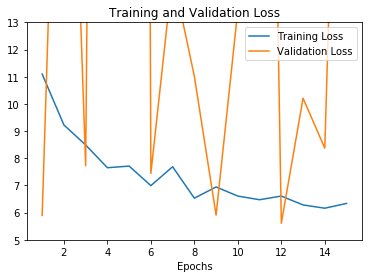

In [25]:
# Visualize training process model 3
epochs = range(1, 16)
plt.ylim(5, 13)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()

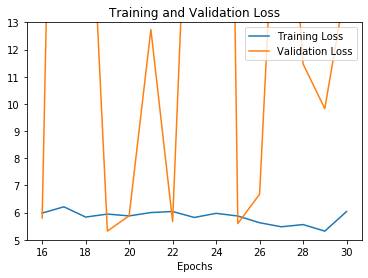

In [29]:
# training cont. epochs (16-30)
epochs = range(16, 31)
plt.ylim(5, 13)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()

In [30]:
# Save model
model.save('model3.h5')

In [102]:
# Function to view a test pic (input = 4D tensor)
def test_pic(L_col):
    # BW input
    ab_col = np.zeros((1,256,256,2))
    Lab_col = np.append(L_col, ab_col, axis=-1)
    Lab_col[:,:,:,0] *= 100
    rgb_col = color.lab2rgb(Lab_col[0])
    plt.imshow(rgb_col)
    
    # predicted color img
    plt.figure()
    ab_col, pred_label = model.predict(L_col)
    Lab_col = np.append(L_col, ab_col, axis=-1)[0]
    Lab_col[:,:,1:3] *= 256
    Lab_col[:,:,1:3] -= 128
    Lab_col[:,:,0] *= 100
    rgb_col = color.lab2rgb(Lab_col)
    plt.imshow(rgb_col)
    
def original(img):
    # ground truth
    ab_col = img[:,:,1:3]
    L_col = img[:,:,0:1]
    Lab_col = np.append(L_col, ab_col, axis=-1)
    Lab_col[:,:,1:3] *= 256
    Lab_col[:,:,1:3] -= 128
    Lab_col[:,:,0] *= 100
    rgb_col = color.lab2rgb(Lab_col)
    plt.imshow(rgb_col)
    

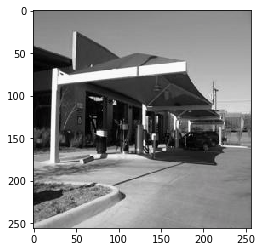

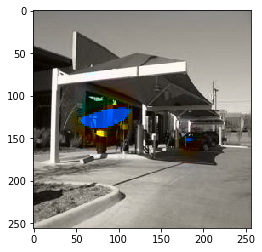

In [103]:
# View results
index = 125
test_pic(img_train[index:index+1,:,:,0:1])

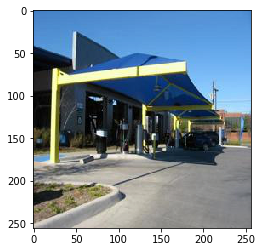

In [99]:
original(img_train[index])

**Model 4**

In [3]:
# Define CNN structure
# same as model 3 but without classifier network

def build_col_model():
    from keras import backend
    input_img = Input(shape=(img_train.shape[1], img_train.shape[2], 1), name="img_input")
    
    # Low-level features network
    LLN_layer1 = Conv2D(64, (3, 3), padding='same', strides=(2,2), name="LLN_layer1")
    LLN_layer2 = Conv2D(128, (3, 3), padding='same', strides=(1,1), name="LLN_layer2")
    LLN_layer3 = Conv2D(128, (3, 3), padding='same', strides=(2,2), name="LLN_layer3")
    LLN_layer4 = Conv2D(256, (3, 3), padding='same', strides=(1,1), name="LLN_layer4")
    LLN_layer5 = Conv2D(256, (3, 3), padding='same', strides=(2,2), name="LLN_layer5")
    LLN_layer6 = Conv2D(512, (3, 3), padding='same', strides=(1,1), name="LLN_layer6")

    local = LLN_layer1(input_img)
    local = BatchNormalization()(local)
    local = Activation("relu")(local)
    local = LLN_layer2(local)
    local = BatchNormalization()(local)
    local = Activation("relu")(local)
    local = LLN_layer3(local)
    local = BatchNormalization()(local)
    local = Activation("relu")(local)
    local = LLN_layer4(local)
    local = BatchNormalization()(local)
    local = Activation("relu")(local)
    local = LLN_layer5(local)
    local = BatchNormalization()(local)
    local = Activation("relu")(local)
    local = LLN_layer6(local)
    local = BatchNormalization()(local)
    local = Activation("relu")(local)

    # Mid-level features network
    mid_layer1 = Conv2D(512, (3, 3), padding='same', strides=(1,1), name="ML_layer1")(local)
    mid_layer1 = BatchNormalization()(mid_layer1)
    mid_layer1 = Activation("relu")(mid_layer1)
    mid_layer2 = Conv2D(256, (3, 3), padding='same', strides=(1,1), name="ML_layer2")(mid_layer1)
    mid_layer2 = BatchNormalization()(mid_layer2)
    mid_layer2 = Activation("relu")(mid_layer2)
    
    # Colorization network
    color_layer1 = Conv2D(128, (3, 3), padding='same', strides=(1,1), name="CN_layer1")(mid_layer2)
    color_layer1 = BatchNormalization()(color_layer1)
    color_layer1 = Activation("relu")(color_layer1)
    upsamp1 = UpSampling2D(name="UpSampling1")(color_layer1)
    color_layer2 = Conv2D(64, (3, 3), padding='same', strides=(1,1), name="CN_layer2")(upsamp1)
    color_layer2 = BatchNormalization()(color_layer2)
    color_layer2 = Activation("relu")(color_layer2)
    color_layer3 = Conv2D(64, (3, 3), padding='same', strides=(1,1), name="CN_layer3")(color_layer2)
    color_layer3 = BatchNormalization()(color_layer3)
    color_layer3 = Activation("relu")(color_layer3)
    upsamp2 = UpSampling2D(name="UpSampling2")(color_layer3)
    color_layer4 = Conv2D(32, (3, 3), padding='same', strides=(1,1), name="CN_layer4")(upsamp2)
    color_layer4 = BatchNormalization()(color_layer4)
    color_layer4 = Activation("relu")(color_layer4)
    output = Conv2D(2, (3, 3), padding='same', strides=(1,1), name="CN_output")(color_layer4)
    output = BatchNormalization()(output)
    output = Activation("sigmoid")(output)
    output = UpSampling2D(name="output")(output)
    
    model = models.Model([input_img], [output])
    model.compile(loss='mse', optimizer='adadelta', metrics=['mse'])
    return model

In [5]:
col_model = build_col_model()
history = col_model.fit(
    img_train[:,:,:,0:1], img_train[:,:,:,1:3],
    batch_size=16,
    epochs=20,
    validation_data=(img_valid[:,:,:,0:1], img_valid[:,:,:,1:3]),
    verbose=2)

Train on 850 samples, validate on 150 samples
Epoch 1/20
 - 125s - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 2/20
 - 106s - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 3/20
 - 106s - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/20
 - 106s - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 5/20
 - 106s - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 6/20
 - 106s - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 7/20
 - 106s - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 8/20
 - 106s - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 9/20
 - 106s - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 10/20
 - 106s - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 11/20
 - 106s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 12/20
 - 10

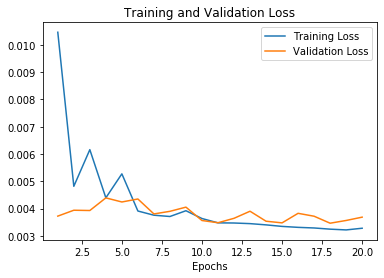

In [161]:
# Visualize training process model 4
epochs = range(1, 21)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()

In [17]:
# Function to view a test pic (input = 4D tensor)
def test_pic_col(L_col):
    # BW input
    ab_col = np.zeros((1,256,256,2))
    Lab_col = np.append(L_col, ab_col, axis=-1)
    Lab_col[:,:,:,0] *= 100
    rgb_col = color.lab2rgb(Lab_col[0])
    plt.imshow(rgb_col)
    
    # predicted color img
    plt.figure()
    ab_col = col_model.predict(L_col)
    Lab_col = np.append(L_col, ab_col, axis=-1)[0]
    Lab_col[:,:,1:3] *= 256
    Lab_col[:,:,1:3] -= 128
    Lab_col[:,:,0] *= 100
    rgb_col = color.lab2rgb(Lab_col)
    plt.imshow(rgb_col)
    
def original_col(img):
    # ground truth
    ab_col = img[:,:,1:3]
    L_col = img[:,:,0:1]
    Lab_col = np.append(L_col, ab_col, axis=-1)
    Lab_col[:,:,1:3] *= 256
    Lab_col[:,:,1:3] -= 128
    Lab_col[:,:,0] *= 100
    rgb_col = color.lab2rgb(Lab_col)
    plt.imshow(rgb_col)
    

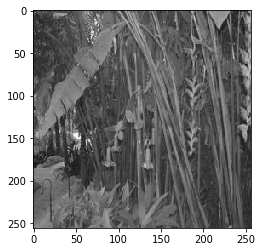

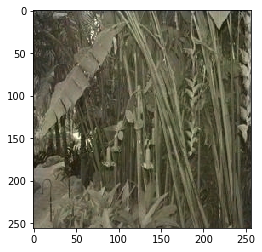

In [158]:
# View results
index = 35
test_pic_col(img_valid[index:index+1,:,:,0:1])

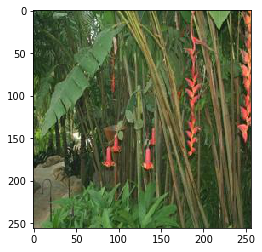

In [159]:
original_col(img_valid[index])

In [162]:
# Save model
col_model.save('model4.h5')